In [15]:
%pip install numpy tdqm matplotlib

Note: you may need to restart the kernel to use updated packages.


In [16]:

"""
Propagation Module
===================
This module defines classes for the medium and base ultrasound wave.
"""


class Medium:
    """
    Class to represent the medium in which the ultrasound wave propagates.

    :param density: Density of the medium. in kg/m^3
    :type density: float
    :param sound_speed: Speed of sound in the medium. in m/s
    :type sound_speed: float
    """

    def __init__(self, density, sound_speed):
        self.density = density
        self.sound_speed = sound_speed


class UltrasoundWave:
    """
    Base class to represent an ultrasound wave.

    :param frequency: The frequency of the wave in Hz.
    :type frequency: float
    :param amplitude: The amplitude of the wave.
    :type amplitude: float
    :param speed: The speed of the wave in the medium.
    :type speed: float
    """

    def __init__(
        self, frequency, amplitude, speed
    ):
        self.frequency = frequency
        self.amplitude = amplitude
        self.speed = speed

    def propagate(self, distance, time):
        """
        Simulate the propagation of the wave. To be implemented by subclasses.

        :param distance: The distance over which the wave propagates.
        :type distance: float
        :param time: The time duration of the propagation.
        :type time: float
        :return: The wave amplitude at the given distance and time.
        :rtype: float
        """
        raise NotImplementedError(
            "Subclasses should implement this!"
        )


# Non Linear Wave 

In [17]:
"""
Nonlinear Wave Module
======================
This module defines classes for nonlinear ultrasound waves.
"""

import numpy as np

class NonlinearUltrasoundWave(UltrasoundWave):
    """
    Class to represent a nonlinear Gaussian ultrasound wave.

    :param frequency: The frequency of the wave in Hz.
    :type frequency: float
    :param amplitude: The amplitude of the wave.
    :type amplitude: float
    :param speed: The speed of the wave in the medium.
    :type speed: float
    :param nonlinearity: Parameter representing the degree of nonlinearity.
    :type nonlinearity: float
    """

    def __init__(
        self,
        frequency,
        amplitude,
        speed,
        nonlinearity,
    ):
        # Validate parameters
        if (
            not isinstance(
                frequency, (int, float)
            )
            or frequency <= 0
        ):
            raise ValueError(
                "Frequency must be a positive number."
            )
        if (
            not isinstance(
                amplitude, (int, float)
            )
            or amplitude <= 0
        ):
            raise ValueError(
                "Amplitude must be a positive number."
            )
        if (
            not isinstance(speed, (int, float))
            or speed <= 0
        ):
            raise ValueError(
                "Speed must be a positive number."
            )
        if (
            not isinstance(
                nonlinearity, (int, float)
            )
            or nonlinearity < 0
        ):
            raise ValueError(
                "Nonlinearity must be a non-negative number."
            )

        # Initialize superclass with frequency, amplitude, and speed
        super().__init__(
            frequency, amplitude, speed
        )
        # Initialize the nonlinearity parameter
        self.nonlinearity = nonlinearity

    def propagate(self, distance, time):
        """
        Simulate the propagation of the nonlinear wave over a fixed distance and time.

        :param distance: The distance over which the wave propagates.
        :type distance: float
        :param time: The time duration of the propagation.
        :type time: float
        :return: The wave amplitude at the given distance and time.
        :rtype: float
        """
        # Validate parameters
        if (
            not isinstance(distance, (int, float))
            or distance < 0
        ):
            raise ValueError(
                "Distance must be a non-negative number."
            )
        if (
            not isinstance(time, (int, float))
            or time < 0
        ):
            raise ValueError(
                "Time must be a non-negative number."
            )

        # Calculate the wavelength
        wavelength = self.speed / self.frequency
        # Calculate the Gaussian envelope
        envelope = np.exp(
            -((distance - self.speed * time) ** 2)
            / (2 * (wavelength**2))
        )
        # Apply the nonlinearity effect
        nonlinear_effect = np.exp(
            -self.nonlinearity * distance
        )
        # Return the resulting amplitude
        return (
            self.amplitude
            * envelope
            * nonlinear_effect
        )


# SIMULATION FILES

In [18]:
"""
Nonlinear Simulation Module
============================
This module defines functions for simulating nonlinear wave propagation.
"""

import numpy as np
from tqdm import tqdm


def simulate_reciver(
    wave_data,
    x_points,
    z_points,
    times,
    listen_pos,
):
    """
    Listen for the wave amplitude at a specified position over time(acts as the reciver).

    :param wave_data: 3D numpy array where each slice is the wave amplitude at a given time.
    :type wave_data: numpy.ndarray
    :param x_points: 1D numpy array representing the x-dimension.
    :type x_points: numpy.ndarray
    :param z_points: 1D numpy array representing the z-dimension (depth).
    :type z_points: numpy.ndarray
    :param times: 1D numpy array representing the time domain.
    :type times: numpy.ndarray
    :param listen_pos: Tuple of the listening position (x, z) in meters.
    :type listen_pos: tuple
    :return: 1D numpy array of wave amplitudes at the listening position over time.
    :rtype: numpy.ndarray
    """
    x_idx = np.argmin(
        np.abs(x_points - listen_pos[0])
    )
    z_idx = np.argmin(
        np.abs(z_points - listen_pos[1])
    )
    print("Listining to Wave")

    return wave_data[:, x_idx, z_idx], times


def simulate_using_steps_optimized(
    wave,
    medium,
    x_start,
    x_stop,
    x_steps,
    z_start,
    z_stop,
    z_steps,
    t_start,
    t_stop,
    t_steps,
    scatterer_pos,
):
    """
    Simulate pressure wave propagation using partial derivatives, optimized version of the simulate_using_steps() using vectorization, with no source term.

    :param wave: An instance of NonlinearUltrasoundWave.
    :type wave: NonlinearUltrasoundWave
    :param medium: An instance of Medium.
    :type medium: Medium
    :param x_start: Start value for the x-dimension.
    :type x_start: float
    :param x_stop: Stop value for the x-dimension.
    :type x_stop: float
    :param x_steps: Number of steps in the x-dimension.
    :type x_steps: int
    :param z_start: Start value for the z-dimension.
    :type z_start: float
    :param z_stop: Stop value for the z-dimension.
    :type t_start: float
    :param t_start: Start value for time doimain
    :param t_stop: Stop value for the time domain.
    :type t_stop: float
    :param t_steps: Number of steps in the time domain.
    :type t_steps: int
    :param scatterer_pos: Tuple of the scatterer's position (x, z).
    :type scatterer_pos: tuple
    :param initial_amplitude: Initial amplitude of the wave (representing voltage).
    :type initial_amplitude: float
    :return: A 3D array of wave amplitudes over time and space, all the x points, all the z_points and all the times
    :rtype: numpy.ndarray
    """
    # Define Parameters
    v = wave.speed  # m/s
    # Intal Temporal Spatial Feild - Calculate dx, dz, and dt based on the provided start, stop, and step
    x_points, dx = np.linspace(
        x_start,
        x_stop,
        x_steps,
        retstep=True,
        endpoint=True,
    )
    z_points, dz = np.linspace(
        z_start,
        z_stop,
        z_steps,
        retstep=True,
        endpoint=True,
    )
    times, dt = np.linspace(
        t_start,
        t_stop,
        t_steps,
        retstep=True,
        endpoint=True,
    )
    # Set number of steps
    nx = len(x_points)
    nz = len(z_points)
    nt = len(times)
    # Set amplitude frequency and acoustic impidance(width)
    amplitude = wave.amplitude
    frequency = wave.frequency
    width = (
        medium.density * wave.speed
    )  # acoustic impidance in kg/m^3

    # Set wave speed constant c = v/(dx/dt) - Ajusts v for spatial and time step
    c = v / (dx / dt)

    # Ensure CFL conditions met
    cfl_number = c * dt / min(dx, dz)

    if cfl_number > 1:
        print("CFL Number", cfl_number)
        raise ValueError(
            "CFL condition not satisfied. Reduce the time step size or increase the spatial step size."
        )

    # Set the centre to be the scatterer
    center_x, center_z = scatterer_pos
    print("Setting Inital Conditions")
    p = np.zeros((nt, nx, nz))

    # Using Paramiters create Inital Conditions
    X, Z = np.meshgrid(
        x_points, z_points, indexing='ij'
    )
    sine_wave = np.cos(2 * np.pi * frequency * 0)
    gaussian_envelope = np.exp(
        -(
            (X - center_x) ** 2
            + (Z - center_z) ** 2
        )
        / (2 * width**2)
    )
    p[0] = (
        amplitude * sine_wave * gaussian_envelope
    )  # without sin wave
    p[1] = p[0]
    print("Running Simulation")

    # loop over the times
    for n in tqdm(
        range(1, nt - 1),
        desc="Simulation Progress",
    ):
        partial_x = (
            p[n, 2:, 1:-1]
            - 2 * p[n, 1:-1, 1:-1]
            + p[n, :-2, 1:-1]
        ) / dx**2
        partial_z = (
            p[n, 1:-1, 2:]
            - 2 * p[n, 1:-1, 1:-1]
            + p[n, 1:-1, :-2]
        ) / dz**2
        right_side = c**2 * (
            partial_x + partial_z
        )
        p[n + 1, 1:-1, 1:-1] = (
            right_side * dt**2
            + 2 * p[n, 1:-1, 1:-1]
            - p[n - 1, 1:-1, 1:-1]
        )
    print("Simulation Complete")
    return p, x_points, z_points, times


def simulate_using_steps(
    wave,
    medium,
    x_start,
    x_stop,
    x_steps,
    z_start,
    z_stop,
    z_steps,
    t_start,
    t_stop,
    t_steps,
    scatterer_pos,
):
    """
    Simulate preasure wave propgation using partial dirivitives.

    :param wave: An instance of NonlinearUltrasoundWave.
    :type wave: NonlinearUltrasoundWave
    :param medium: An instance of Medium.
    :type medium: Medium
    :param x_start: Start value for the x-dimension.
    :type x_start: float
    :param x_stop: Stop value for the x-dimension.
    :type x_stop: float
    :param x_steps: Number of steps in the x-dimension.
    :type x_steps: int
    :param z_start: Start value for the z-dimension.
    :type z_start: float
    :param z_stop: Stop value for the z-dimension.
    :type t_start: float
    :param t_start: Start value for time doimain
    :param t_stop: Stop value for the time domain.
    :type t_stop: float
    :param t_steps: Number of steps in the time domain.
    :type t_steps: int
    :param scatterer_pos: Tuple of the scatterer's position (x, z).
    :type scatterer_pos: tuple
    :param initial_amplitude: Initial amplitude of the wave (representing voltage).
    :type initial_amplitude: float
    :return: A 3D array of wave amplitudes over time and space, all the x points, all the z_points and all the times
    :rtype: numpy.ndarray
    """

    def discretize_pressure_wave(
        p, ndt, idx, jdz
    ):
        """
        Discretize the pressure wave function into discrete values of time and position.

        Equation:
        p(x, z, t) → p_{i,j}^n = p(ndt, idx, jdz)

        :param p: Pressure wave function.
        :type p: function
        :param ndt: Discrete time value.
        :type ndt: float
        :param idx: Discrete x position value.
        :type idx: float
        :param jdz: Discrete z position value.
        :type jdz: float
        :return: Discretized pressure wave value.
        :rtype: float
        """
        # Call the pressure wave function with discrete time and position values
        return p(ndt, idx, jdz)

    def partial_derivative_t(
        p_next, p_current, p_prev, dt
    ):
        """
        Compute the second partial derivative of the pressure wave function with respect to time.

        Equation:
        ∂²p(x, t)/∂t² ≈ (p_{i,j}^{n+1} - 2p_{i,j}^n + p_{i,j}^{n-1}) / dt²

        :param p_next: Pressure wave value at next time step.
        :type p_next: float
        :param p_current: Pressure wave value at current time step.
        :type p_current: float
        :param p_prev: Pressure wave value at previous time step.
        :type p_prev: float
        :param dt: Time step size.
        :type dt: float
        :return: Second partial derivative with respect to time.
        :rtype: float
        """
        # Compute the second partial derivative with respect to time
        return (
            p_next - 2 * p_current + p_prev
        ) / dt**2

    def partial_derivative_x(
        p_next_x, p_current, p_prev_x, dx
    ):
        """
        Compute the second partial derivative of the pressure wave function with respect to the x coordinate.

        Equation:
        ∂²p/∂x² ≈ (p_{i+1,j}^n - 2p_{i,j}^n + p_{i-1,j}^n) / dx²

        :param p_next_x: Pressure wave value at next x position.
        :type p_next_x: float
        :param p_current: Pressure wave value at current x position.
        :type p_current: float
        :param p_prev_x: Pressure wave value at previous x position.
        :type p_prev_x: float
        :param dx: x position step size.
        :type dx: float
        :return: Second partial derivative with respect to x.
        :rtype: float
        """
        # Compute the second partial derivative with respect to x
        return (
            p_next_x - 2 * p_current + p_prev_x
        ) / dx**2

    def partial_derivative_z(
        p_next_z, p_current, p_prev_z, dz
    ):
        """
        Compute the second partial derivative of the pressure wave function with respect to the z coordinate.

        Equation:
        ∂²p/∂z² ≈ (p_{i,j+1}^n - 2p_{i,j}^n + p_{i,j-1}^n) / dz²

        :param p_next_z: Pressure wave value at next z position.
        :type p_next_z: float
        :param p_current: Pressure wave value at current z position.
        :type p_current: float
        :param p_prev_z: Pressure wave value at previous z position.
        :type p_prev_z: float
        :param dz: z position step size.
        :type dz: float
        :return: Second partial derivative with respect to z.
        :rtype: float
        """
        # Compute the second partial derivative with respect to z
        return (
            p_next_z - 2 * p_current + p_prev_z
        ) / dz**2

    def main_equation(
        p_next,
        p_current,
        p_prev,
        c,
        partial_x,
        partial_z,
        s,
        dt,
    ):
        """
        Combine the partial derivatives into the main equation for the numerical method.

        Equation:
        (p_{i,j}^{n+1} - 2p_{i,j}^n + p_{i,j}^{n-1}) / dt² = c²(∂²p/∂x² + ∂²p/∂z²) + s_{i,j}^n

        :param p_next: Pressure wave value at next time step.
        :type p_next: float
        :param p_current: Pressure wave value at current time step.
        :type p_current: float
        :param p_prev: Pressure wave value at previous time step.
        :type p_prev: float
        :param c: Wave speed constant.
        :type c: float
        :param partial_x: Second partial derivative with respect to x.
        :type partial_x: float
        :param partial_z: Second partial derivative with respect to z.
        :type partial_z: float
        :param s: Source term.
        :type s: float
        :param dt: Time step size.
        :type dt: float
        :return: Left side and right side of the main equation.
        :rtype: tuple
        """
        # Compute the left side of the main equation
        left_side = (
            p_next - 2 * p_current + p_prev
        ) / dt**2
        # Compute the right side of the main equation
        right_side = (
            c**2 * (partial_x + partial_z) + s
        )
        # Return the left and right sides of the main equation
        return left_side, right_side

    # Define the initial pressure wave function
    def initial_pressure_wave(
        x,
        z,
        t,
        amplitude,
        frequency,
        width,
        center_x,
        center_z,
    ):
        """
        Generate an initial pressure wave with control over amplitude, frequency, and pulsing in cycles.

        :param x: x position.
        :type x: float
        :param z: z position.
        :type z: float
        :param t: Time.
        :type t: float
        :param amplitude: Amplitude of the wave.
        :type amplitude: float
        :param frequency: Frequency of the wave.
        :type frequency: float
        :param cycles: Number of cycles in the pulse.
        :type cycles: int
        :param width: Width of the Gaussian envelope.
        :type width: float
        :param center_x: Center position of the Gaussian envelope in x.
        :type center_x: float
        :param center_z: Center position of the Gaussian envelope in z.
        :type center_z: float
        :return: Initial pressure wave value.
        :rtype: float
        """
        # Sinusoidal function for the pulsing behavior
        sine_wave = np.cos(
            2 * np.pi * frequency * t
        )

        # Gaussian envelope for the spatial distribution
        gaussian_envelope = np.exp(
            -(
                (x - center_x) ** 2
                + (z - center_z) ** 2
            )
            / (2 * width**2)
        )  # pulled out / (2 * width**2)

        # Combine both to form the initial pressure wave
        # return amplitude * sine_wave * gaussian_envelope
        return (
            amplitude
            * sine_wave
            * gaussian_envelope
        )

    v = wave.speed
    # Calculate dx, dz, and dt based on the provided start, stop, and step
    x_points, dx = np.linspace(
        x_start,
        x_stop,
        x_steps,
        retstep=True,
        endpoint=True,
    )
    z_points, dz = np.linspace(
        z_start,
        z_stop,
        z_steps,
        retstep=True,
        endpoint=True,
    )
    times, dt = np.linspace(
        t_start,
        t_stop,
        t_steps,
        retstep=True,
        endpoint=True,
    )
    nx = len(x_points)
    nz = len(z_points)
    nt = len(times)
    amplitude = wave.amplitude
    frequency = wave.frequency
    width = (
        medium.density * wave.speed
    )  # acoustic impidance in kg/m^3
    c = v / (dx / dt)
    cfl_number = c * dt / min(dx, dz)

    if cfl_number > 1:
        raise ValueError(
            "CFL condition not satisfied. Reduce the time step size or increase the spatial step size."
        )

    center_x, center_z = scatterer_pos
    p = np.zeros((nt, nx, nz))

    # Set initial conditions
    for i in range(nx):
        for j in range(nz):
            p[0, i, j] = initial_pressure_wave(
                i * dx,
                j * dz,
                0,
                amplitude,
                frequency,
                width,
                center_x * 10**-1,
                center_z * 10**-1,
            )
            p[1, i, j] = p[
                0, i, j
            ]  # Initial condition for the second time step

    # Run the simulation
    for n in tqdm(
        range(1, nt - 1),
        desc="Simulation Progress",
    ):
        # print("running time step", n)
        for i in range(1, nx - 1):
            for j in range(1, nz - 1):
                # Compute partial derivatives
                partial_x = partial_derivative_x(
                    p[n, i + 1, j],
                    p[n, i, j],
                    p[n, i - 1, j],
                    dx,
                )
                partial_z = partial_derivative_z(
                    p[n, i, j + 1],
                    p[n, i, j],
                    p[n, i, j - 1],
                    dz,
                )
                s = 0  # Source term, could be defined as needed

                # Compute the next pressure wave value using the main equation
                left_side, right_side = (
                    main_equation(
                        p[n + 1, i, j],
                        p[n, i, j],
                        p[n - 1, i, j],
                        c,
                        partial_x,
                        partial_z,
                        s,
                        dt,
                    )
                )
                # take only the right side for our data
                p[n + 1, i, j] = (
                    right_side * dt**2
                    + 2 * p[n, i, j]
                    - p[n - 1, i, j]
                )

    # p now contains the pressure wave values for all time steps and spatial points
    print("Simulation Complete")
    return p, x_points, z_points, times


def simulate_using_steps_optimized_with_cont_src(
    wave,
    medium,
    x_start,
    x_stop,
    x_steps,
    z_start,
    z_stop,
    z_steps,
    t_start,
    t_stop,
    t_steps,
    scatterer_pos,
):
    """
    Simulate pressure wave propagation using partial derivatives, optimized version of the original function using vectorization, with a point source term.

    :param wave: An instance of NonlinearUltrasoundWave.
    :type wave: NonlinearUltrasoundWave
    :param medium: An instance of Medium.
    :type medium: Medium
    :param x_start: Start value for the x-dimension.
    :type x_start: float
    :param x_stop: Stop value for the x-dimension.
    :type x_stop: float
    :param x_steps: Number of steps in the x-dimension.
    :type x_steps: int
    :param z_start: Start value for the z-dimension.
    :type z_start: float
    :param z_stop: Stop value for the z-dimension.
    :type t_start: float
    :param t_start: Start value for time doimain
    :param t_stop: Stop value for the time domain.
    :type t_stop: float
    :param t_steps: Number of steps in the time domain.
    :type t_steps: int
    :param scatterer_pos: Tuple of the scatterer's position (x, z).
    :type scatterer_pos: tuple
    :param initial_amplitude: Initial amplitude of the wave (representing voltage).
    :type initial_amplitude: float
    :return: A 3D array of wave amplitudes over time and space, all the x points, all the z_points and all the times
    :rtype: numpy.ndarray
    """
    v = wave.speed
    # Calculate dx, dz, and dt based on the provided start, stop, and step
    x_points, dx = np.linspace(
        x_start,
        x_stop,
        x_steps,
        retstep=True,
        endpoint=True,
    )
    z_points, dz = np.linspace(
        z_start,
        z_stop,
        z_steps,
        retstep=True,
        endpoint=True,
    )
    times, dt = np.linspace(
        t_start,
        t_stop,
        t_steps,
        retstep=True,
        endpoint=True,
    )
    nx = len(x_points)
    nz = len(z_points)
    nt = len(times)
    amplitude = wave.amplitude
    frequency = wave.frequency
    width = (
        medium.density * wave.speed
    )  # acoustic impidance in kg/m^3
    c = v / (dx / dt)
    cfl_number = c * dt / min(dx, dz)

    if cfl_number > 1:
        raise ValueError(
            "CFL condition not satisfied. Reduce the time step size or increase the spatial step size."
        )

    center_x, center_z = scatterer_pos
    p = np.zeros((nt, nx, nz))

    X, Z = np.meshgrid(
        x_points, z_points, indexing='ij'
    )
    sine_wave = np.cos(2 * np.pi * frequency * 0)
    gaussian_envelope = np.exp(
        -(
            (X - center_x) ** 2
            + (Z - center_z) ** 2
        )
        / (2 * width**2)
    )
    p[0] = (
        amplitude * sine_wave * gaussian_envelope
    )  # without sin wave
    p[1] = p[0]

    for n in tqdm(
        range(1, nt - 1),
        desc="Simulation Progress",
    ):
        partial_x = (
            p[n, 2:, 1:-1]
            - 2 * p[n, 1:-1, 1:-1]
            + p[n, :-2, 1:-1]
        ) / dx**2
        partial_z = (
            p[n, 1:-1, 2:]
            - 2 * p[n, 1:-1, 1:-1]
            + p[n, 1:-1, :-2]
        ) / dz**2
        right_side = c**2 * (
            partial_x + partial_z
        )

        # Final Equation without source term
        p[n + 1, 1:-1, 1:-1] = (
            right_side * dt**2
            + 2 * p[n, 1:-1, 1:-1]
            - p[n - 1, 1:-1, 1:-1]
        )

        # Add source term
        source_term = amplitude * np.cos(
            2 * np.pi * frequency * times[n]
        )
        p[
            n + 1, center_x, center_z
        ] += source_term

    return p, x_points, z_points, times


def simulate_using_steps_optimized_with_pulse_source(
    wave,
    medium,
    x_start,
    x_stop,
    x_steps,
    z_start,
    z_stop,
    z_steps,
    t_start,
    t_stop,
    t_steps,
    scatterer_pos,
):
    """
    Simulate pressure wave propagation using partial derivatives, optimized version of the original function using vectorization, with a gaussian pulse source term.

    :param wave: An instance of NonlinearUltrasoundWave.
    :type wave: NonlinearUltrasoundWave
    :param medium: An instance of Medium.
    :type medium: Medium
    :param x_start: Start value for the x-dimension.
    :type x_start: float
    :param x_stop: Stop value for the x-dimension.
    :type x_stop: float
    :param x_steps: Number of steps in the x-dimension.
    :type x_steps: int
    :param z_start: Start value for the z-dimension.
    :type z_start: float
    :param z_stop: Stop value for the z-dimension.
    :type t_start: float
    :param t_start: Start value for time doimain
    :param t_stop: Stop value for the time domain.
    :type t_stop: float
    :param t_steps: Number of steps in the time domain.
    :type t_steps: int
    :param scatterer_pos: Tuple of the scatterer's position (x, z).
    :type scatterer_pos: tuple
    :param initial_amplitude: Initial amplitude of the wave (representing voltage).
    :type initial_amplitude: float
    :return: A 3D array of wave amplitudes over time and space, all the x points, all the z_points and all the times
    :rtype: numpy.ndarray
    """
    v = wave.speed
    # Calculate dx, dz, and dt based on the provided start, stop, and step
    x_points, dx = np.linspace(
        x_start,
        x_stop,
        x_steps,
        retstep=True,
        endpoint=True,
    )
    z_points, dz = np.linspace(
        z_start,
        z_stop,
        z_steps,
        retstep=True,
        endpoint=True,
    )
    times, dt = np.linspace(
        t_start,
        t_stop,
        t_steps,
        retstep=True,
        endpoint=True,
    )
    nx = len(x_points)
    nz = len(z_points)
    nt = len(times)
    amplitude = wave.amplitude
    frequency = wave.frequency
    width = (
        medium.density * wave.speed
    )  # acoustic impidance
    c = v / (dx / dt)
    cfl_number = c * dt / min(dx, dz)

    if cfl_number > 1:
        raise ValueError(
            "CFL condition not satisfied. Reduce the time step size or increase the spatial step size."
        )

    center_x, center_z = scatterer_pos
    p = np.zeros((nt, nx, nz))

    X, Z = np.meshgrid(
        x_points, z_points, indexing='ij'
    )
    sine_wave = np.cos(2 * np.pi * frequency * 0)
    gaussian_envelope = np.exp(
        -(
            (X - center_x) ** 2
            + (Z - center_z) ** 2
        )
        / (2 * width**2)
    )
    p[0] = (
        amplitude * sine_wave * gaussian_envelope
    )  # without sin wave
    p[1] = p[0]
    # Creating the Gaussian pulse source term
    src = amplitude * np.exp(
        -((times - nt // 2) ** 2) / (2 * width**2)
    )
    sine_wave = np.sin(
        2 * np.pi * frequency * times
    )
    pulse = src

    for n in tqdm(
        range(1, nt - 1),
        desc="Simulation Progress",
    ):
        partial_x = (
            p[n, 2:, 1:-1]
            - 2 * p[n, 1:-1, 1:-1]
            + p[n, :-2, 1:-1]
        ) / dx**2
        partial_z = (
            p[n, 1:-1, 2:]
            - 2 * p[n, 1:-1, 1:-1]
            + p[n, 1:-1, :-2]
        ) / dz**2
        right_side = c**2 * (
            partial_x + partial_z
        )

        # Final Equation without source term
        p[n + 1, 1:-1, 1:-1] = (
            right_side * dt**2
            + 2 * p[n, 1:-1, 1:-1]
            - p[n - 1, 1:-1, 1:-1]
        )

        # Add pulse source term
        p[n + 1, center_x, center_z] += pulse[n]

    return p, x_points, z_points, times


# ANIMATION FILE

In [19]:
"""
Data Visualization Module
==========================
This module defines functions for visualizing wave and RF signal data.
"""

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import (
    FuncAnimation,
    FFMpegWriter,
)
import matplotlib.colors as mcolors


def animate_wave(
    wave_data,
    rfsignal,
    x_points,
    z_points,
    times,
    scatterer_pos,
    receiver_pos,
    interval=20,
    title='Wave Animation',
    file="wave_animation",
):
    """
    Animates the wave data over time, representing the amplitude as a colorbar and the radio frequency signal as a sizemograph.

    :param wave_data: 3D numpy array where each slice is the wave amplitude at a given time.
    :type wave_data: numpy.ndarray
    :param x_points: 1D numpy array representing the x-dimension.
    :type x_points: numpy.ndarray
    :param z_points: 1D numpy array representing the z-dimension (depth).
    :type z_points: numpy.ndarray
    :param times: 1D numpy array representing the time domain.
    :type times: numpy.ndarray
    :param scatterer_pos: Tuple of the scatterer's position (x, z).
    :type scatterer_pos: tuple
    :param receiver_pos: Tuple of the receiver's position (x, z).
    :type receiver_pos: tuple
    :param interval: Time between frames in milliseconds.
    :type interval: int
    :param title: Title of the animation.
    :param file: File Name without extension
    :type title: str
    """
    # Create the figure and axis objects
    fig, (ax_wave, ax_signal) = plt.subplots(
        1, 2, figsize=(12, 6)
    )
    fig.suptitle(title)

    # Define the colormap with a center value of white
    cmap = plt.get_cmap('seismic_r')

    # Determine the max amplitude for the color scale
    max_val = np.max(np.abs(wave_data))
    vmin, vmax = -max_val, max_val
    norm = mcolors.TwoSlopeNorm(
        vmin=vmin, vcenter=0, vmax=vmax
    )

    # Create the initial plot with a color bar
    cax = ax_wave.imshow(
        wave_data[0],
        cmap=cmap,
        norm=norm,
        extent=[
            x_points.min(),
            x_points.max(),
            z_points.min(),
            z_points.max(),
        ],
        origin='lower',
    )
    # pylint: disable=unused-variable
    colorbar = fig.colorbar(
        cax, ax=ax_wave, label='Amplitude'
    )
    # pylint: enable=unused-variable

    # Add scatterer and receiver markers in (z,x) - conveerts (x,z) to (z,x)
    ax_wave.plot(
        scatterer_pos[1],
        scatterer_pos[0],
        'ro',
        label='Scatterer',
    )
    ax_wave.plot(
        receiver_pos[1],
        receiver_pos[0],
        'ks',
        label='Receiver',
    )

    # Add legend
    ax_wave.legend()

    # Plot settings for seismogram
    ax_signal.set_title('Radiofrequency Signal')
    ax_signal.set_xlabel('Time [s]')
    ax_signal.set_ylabel('Amplitude')
    ax_signal.grid(True)

    # Initialize the seismogram line
    (seismogram,) = ax_signal.plot(
        [], [], 'b-', label='Finite Difference'
    )

    # Initialize the progress bar
    progress_bar = tqdm(
        total=len(times),
        desc="Rendering Animation",
    )

    # set sizmogram max and min
    siz_max = np.max(rfsignal)
    siz_min = np.min(rfsignal)

    def update(frame):
        """
        Update function for each frame of the animation.
        :param frame: Current frame number.
        :type frame: int
        """
        # Update the seismograph
        seismogram.set_data(
            times[:frame], rfsignal[:frame]
        )
        ax_signal.set_xlim(0, times[frame])
        ax_signal.set_ylim(siz_min, siz_max)

        # Update the wave plot
        cax.set_array(wave_data[frame])
        ax_wave.set_title(
            f'Time Step (nt) = {frame}'
        )
        ax_wave.set_xlabel('x-dimension (m)')
        ax_wave.set_ylabel(
            'z-dimension (depth in m)'
        )

        # Update the progress bar
        progress_bar.update(1)
        return cax, seismogram

    # Create the animation object
    ani = FuncAnimation(
        fig,
        update,
        frames=len(times),
        interval=interval,
        repeat=False,
    )

    # Save the animation to a video file
    writer = FFMpegWriter(
        fps=30,
        metadata=dict(artist='Me'),
        bitrate=1800,
    )
    # DISABLED ON JUPITER NOTEBOOK APART OF THE ACTUAL CODE
    ani.save(
        f"../animations/{file}.mp4", writer=writer
    )

    # Close the progress bar
    progress_bar.close()
    plt.show()


# MAIN FILE


Setting Inital Conditions
Running Simulation


Simulation Progress: 100%|██████████| 598/598 [00:00<00:00, 2230.51it/s]


Simulation Complete
Wavefield Summary:
Min value: -2.0156776709751057e-06
Max value: 6.897370004490609e-06
Mean value: 8.923316435874754e-09
Listining to Wave
Rendering Animation


Rendering Animation:   0%|          | 0/600 [00:00<?, ?it/s]/tmp/ipykernel_6740/714641787.py:133: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax_signal.set_xlim(0, times[frame])
Rendering Animation: 601it [01:19,  7.55it/s]                         


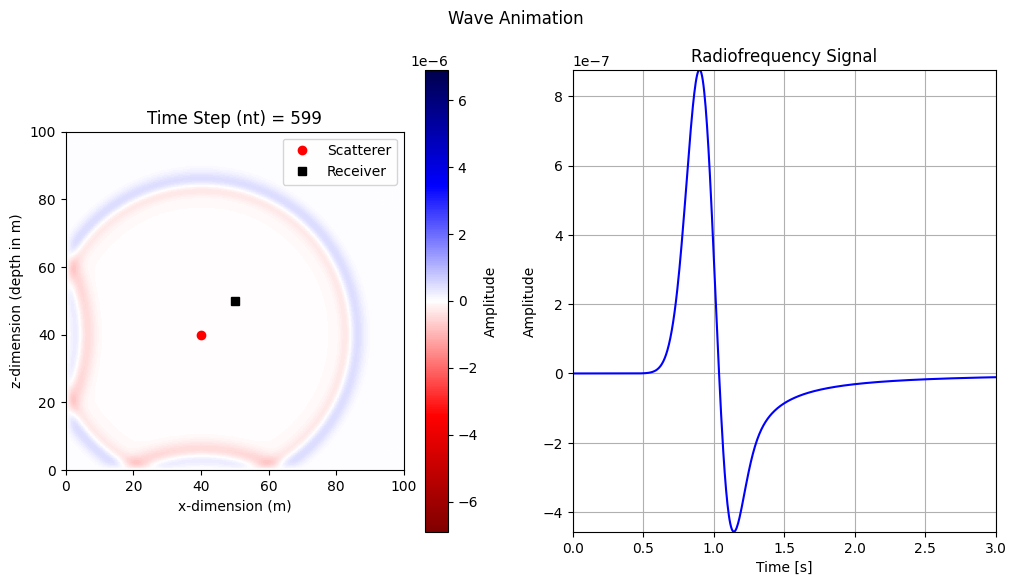

In [20]:
"""
Main Module
============
This module runs the ultrasound simulation and visualization. Here we configure the simulation and run it.
"""
# NOTE LOCAL IMPORTS REMOVED FOR JUPITER NOTEBOOK
import numpy as np


def main():
    """
    Main function to run the ultrasound simulation and visualization.
    """

    # Define simulation parameters
    # The resolution of the grid will be stop/steps in metres ie,
    # x_stop = 1000 x_step = 100 => 10m resolution
    #    - best resolution seeems to be 0.5 for the x and z steps, having an index every 0.5m
    t_start = 0
    # controls total simulation time - ie are we simulating 3 sec or whatnot must be an integer
    t_stop = 3  # in sec - the longer the time the better the resolution
    # temporal resolution (dt = 0.005)
    # - smaller this number better the aproximation
    # - can never model real time due to calculs constraint(were using descrete math)
    t_steps = (
        2 * t_stop * 100
    )  # BEST RESOLUTION FOR CONSTRAINTS

    # Spatial Resolution
    x_start = 0
    x_stop = 100  # in m
    x_steps = (
        2 * x_stop
    )  # Spaital Resolution based on grid size

    z_start = 0
    z_stop = 100  # in m
    z_steps = (
        2 * z_stop
    )  # Spatial resolution based on grid size

    # formated in (x,z)
    scatterer_pos = (40, 40)  # in m
    receiver_pos = (50, 50)  # in m
    initial_amplitude = 7e-6  # Adjust this value to change wave strength
    frequency = 5e5  # 5 MHz

    # Define medium properties
    medium = Medium(
        density=1.081e-3, sound_speed=1530
    )

    # Wave Speed
    wave_speed = 1530

    # Build the wave
    wave = NonlinearUltrasoundWave(
        frequency=frequency,
        amplitude=initial_amplitude,
        speed=wave_speed,
        nonlinearity=0.01,
    )

    # SIMULATE
    wavefield, x_points, z_points, times = (
        simulate_using_steps_optimized(
            wave,
            medium,
            x_start,
            x_stop,
            x_steps,
            z_start,
            z_stop,
            z_steps,
            t_start,
            t_stop,
            t_steps,
            scatterer_pos,
        )
    )

    # SIMULATION RESULTS
    print("Wavefield Summary:")
    print("Min value:", np.min(wavefield))
    print("Max value:", np.max(wavefield))
    print("Mean value:", np.mean(wavefield))

    # Create the sizemogram from the reciver
    rf_signal, times = simulate_reciver(
        wavefield,
        x_points,
        z_points,
        times,
        receiver_pos,
    )

    # RENDER
    print("Rendering Animation")
    animate_wave(
        wavefield,
        rf_signal,
        x_points,
        z_points,
        times,
        scatterer_pos,
        receiver_pos,
        file="using_steps_no_source",
    )


if __name__ == "__main__":
    main()
